# 7. 의사결정나무(Decision Tree)
- 분류와 회귀에 사용되는 지도 학습 방법
- 데이터 특성으로부터 추론된 결정 규칙을 통해 값을 예측
- 트리의 깊이가 깊을수록 복잡한 모델
- 장점
    - 이해와 해석이 쉽다
    - 시각화가 용이하다
    - 많은 데이터 전처리가 필요하지 않다
    - 수치형과 범주형 데이터 모두를 다룰 수 있다

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import graphviz
plt.style.use(["seaborn-whitegrid"])

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, export_text, plot_tree
from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

/var/folders/79/v97_0rqs3p34z9xx6y57xks80000gn/T/ipykernel_4547/1402884581.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-whitegrid"])


## 분류 - DecisionTreeClassifier()
- 분류를 위한 결정트리 모델
- 두 개의 배열 X, y를 입력 받음
    - X는 [n_samples, n_features] 크기의 데이터 특성 배열

In [2]:
# 데이터 생성
X = [[0, 1], [1, 2]]
y = [0, 1]

# 의사결정나무 학습
model = DecisionTreeClassifier()
model.fit(X, y)
print(model.predict(np.array([2., 2.]).reshape(1, -1)))
print(model.predict_proba(np.array([2., 2.]).reshape(1, -1)))

[1]
[[0. 1.]]


### 붓꽃 데이터

In [28]:
# 붓꽃 데이터 불러오기
iris = load_iris()
X, y = load_iris(return_X_y=True)

# 데이터프레임으로 만들기
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["Target"] = iris.target
species = iris_df["Target"].astype(dtype="category").cat.rename_categories(iris.target_names)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [35]:
# 학습/테스트 데이터 셋 분리
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=123)

# 의사결정나무 학습
model = DecisionTreeClassifier(random_state=123)
model.fit(X_train, y_train)

# 모델 평가
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 1.0
평가 데이터 점수: 0.9666666666666667


#### 교차검증 수행

In [39]:
# 의사결정나무
model = DecisionTreeClassifier(random_state=123)

# cross_val_score로 교차검증 수행
cross_val_score(estimator=model,
                X=iris.data, y=iris.target,
                verbose=True,
                cv=5,
                n_jobs=multiprocessing.cpu_count())

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


array([0.96666667, 0.96666667, 0.9       , 0.96666667, 1.        ])

#### GridSearchCV 수행

In [51]:
# 의사결정나무
model = DecisionTreeClassifier(random_state=123)

# 파라미터 후보군
param_grid = {"min_samples_split": [2, 3, 4, 5],
              "min_samples_leaf": [1, 2, 3, 4, 5],
              "max_depth": [2, 3, 4]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=model,
                  param_grid=param_grid,
                  verbose=True,
                  cv=5,
                  n_jobs=multiprocessing.cpu_count())
gs.fit(X_train, y_train)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print(gs.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.9166666666666667


#### 학습된 결정 트리 시각화

In [52]:
# 의사결정나무 학습
model = DecisionTreeClassifier(random_state=123)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

- 텍스트를 통한 시각화

In [53]:
print(export_text(decision_tree=model,
                  feature_names=iris.feature_names))

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 5.35
|   |   |   |--- sepal length (cm) <= 4.95
|   |   |   |   |--- petal width (cm) <= 1.35
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- petal width (cm) >  1.35
|   |   |   |   |   |--- class: 2
|   |   |   |--- sepal length (cm) >  4.95
|   |   |   |   |--- petal length (cm) <= 4.95
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- petal length (cm) >  4.95
|   |   |   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |   |   |--- class: 1
|   |   |--- petal length (cm) >  5.35
|   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- sepal length (cm) <= 6.05
|   |   |   |   |--- class: 1
|   |   |   |--- sepal length (cm) >  6.05
|   |   |   |   |--- class: 2
|   |   |--- 

- plot_tree를 사용한 시각화

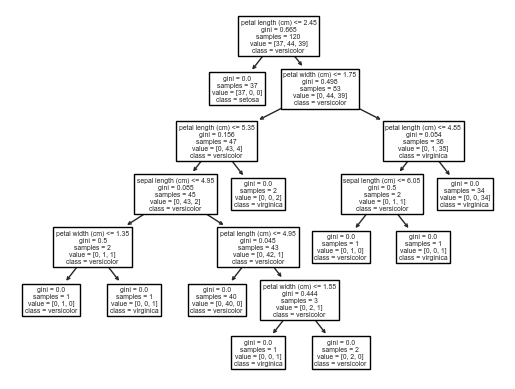

In [54]:
plot_tree(decision_tree=model,
          feature_names=iris.feature_names,
          class_names=iris.target_names);

- graphviz를 사용한 시각화

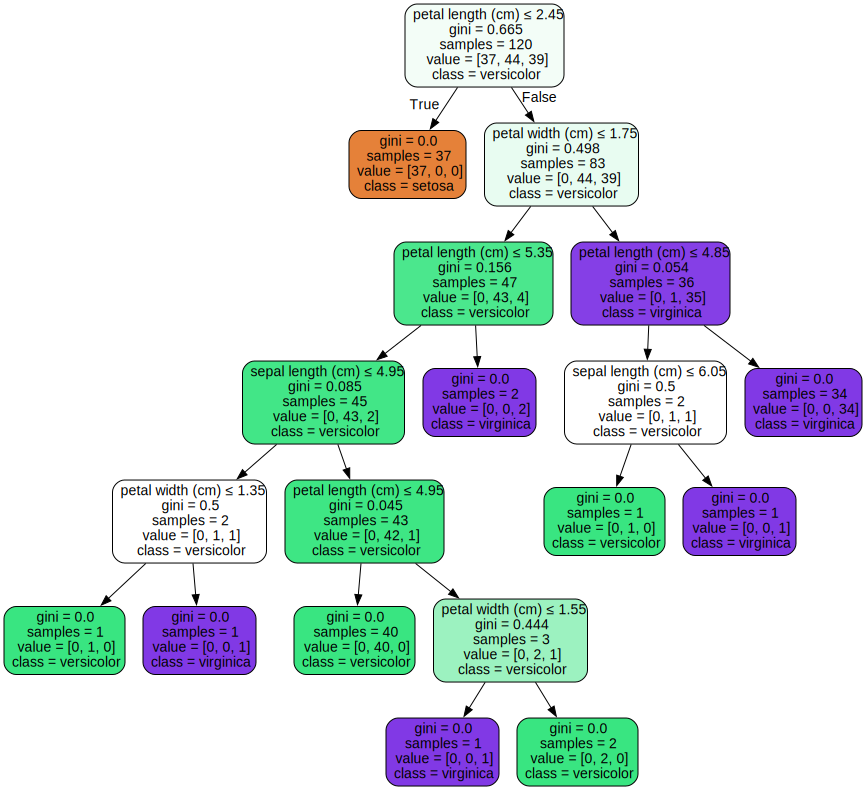

In [55]:
dot_data = export_graphviz(decision_tree=model,
                           feature_names=iris.feature_names,
                           class_names=iris.target_names,
                           filled=True, rounded=True,
                           special_characters=True)
graphviz.Source(dot_data)

- 결정경계 시각화

In [56]:
# 격자 그리드 형태 데이터들을 생성할 함수
def get_meshgrid(x, y, step):
    xx, yy = np.meshgrid(np.arange(x.min()-1, x.max()+1, step), np.arange(y.min()-1, y.max()+1, step))
    return xx, yy

# 그래프에 각 클래스에 대한 영역을 구분해줄 함수
def get_contourf(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return plt.contourf(xx, yy, Z, **params)

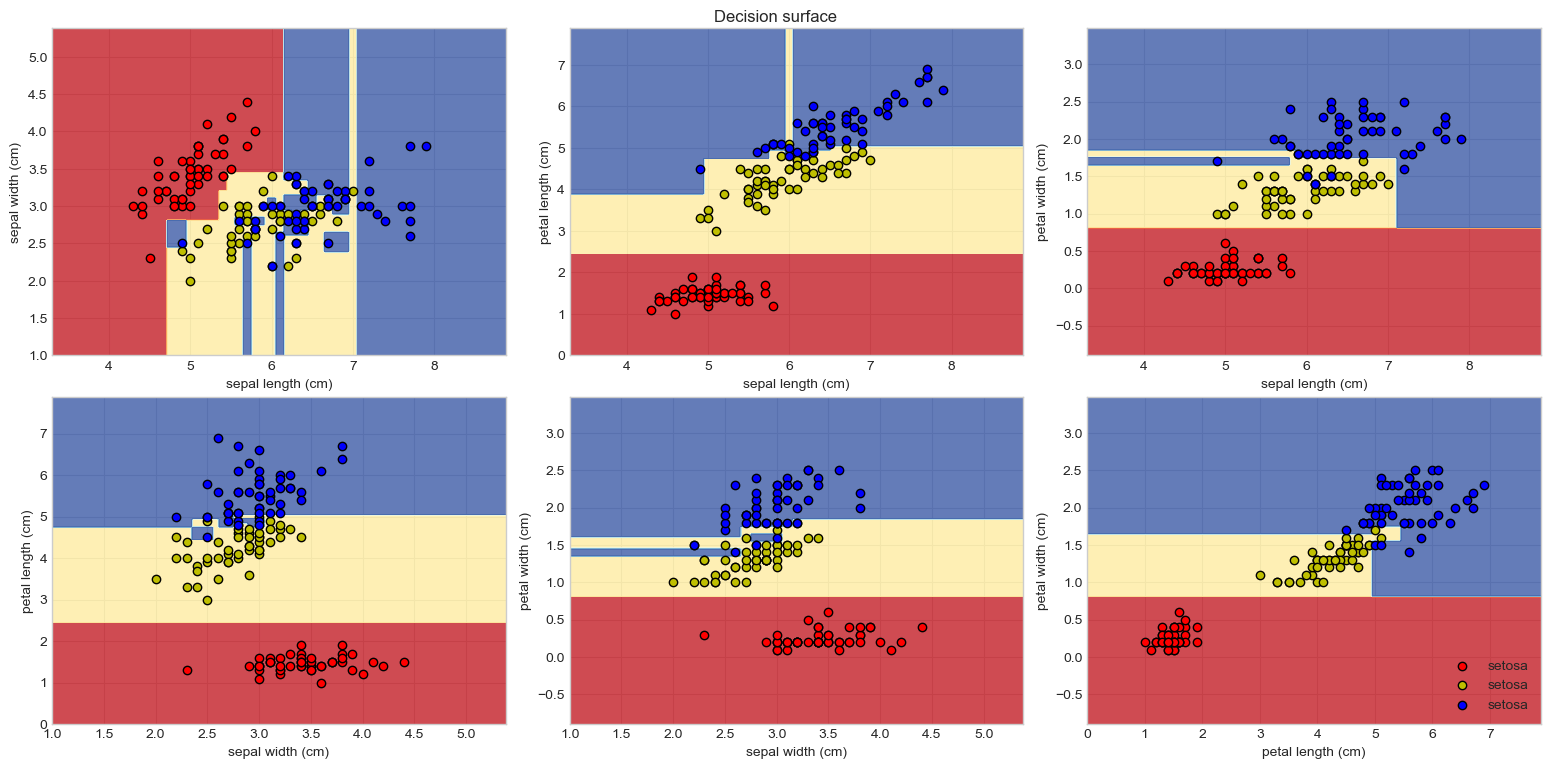

In [57]:
# 격자 그리드 데이터들의 간격
step = 0.02

# 산점도 색
colors = ["r", "y", "b"]

# figure 크기 설정
plt.figure(figsize=(16, 8))

# 붓꽃 데이터의 피처 묶음별로 그래프 생성
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    X = iris.data[:, pair]
    y = iris.target

    # 의사결정나무 학습
    model = DecisionTreeClassifier(random_state=1)
    model.fit(X, y)

    # subplot 생성
    plt.subplot(2, 3, pairidx + 1)

    # 각 클래스의 영역을 구분할 데이터들을 생성
    xx, yy = get_meshgrid(X[:, 0], X[:, 1], step)

    # 영역을 구분할 데이터들을 분류 및 영역 구분
    get_contourf(model, xx, yy, alpha=0.8, cmap=plt.cm.RdYlBu)

    # 분류된 데이터들을 산점도로 시각화
    for i in range(len(np.unique(y))):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=colors[i], label=species[i], edgecolors="k")
    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.tight_layout(pad=2.5, w_pad=1.0, h_pad=0.5)

plt.suptitle("Decision surface")
plt.legend(loc="lower right")
plt.axis("tight")
plt.show()


- 하이퍼파라미터를 변경한 후 결정경계 시각화

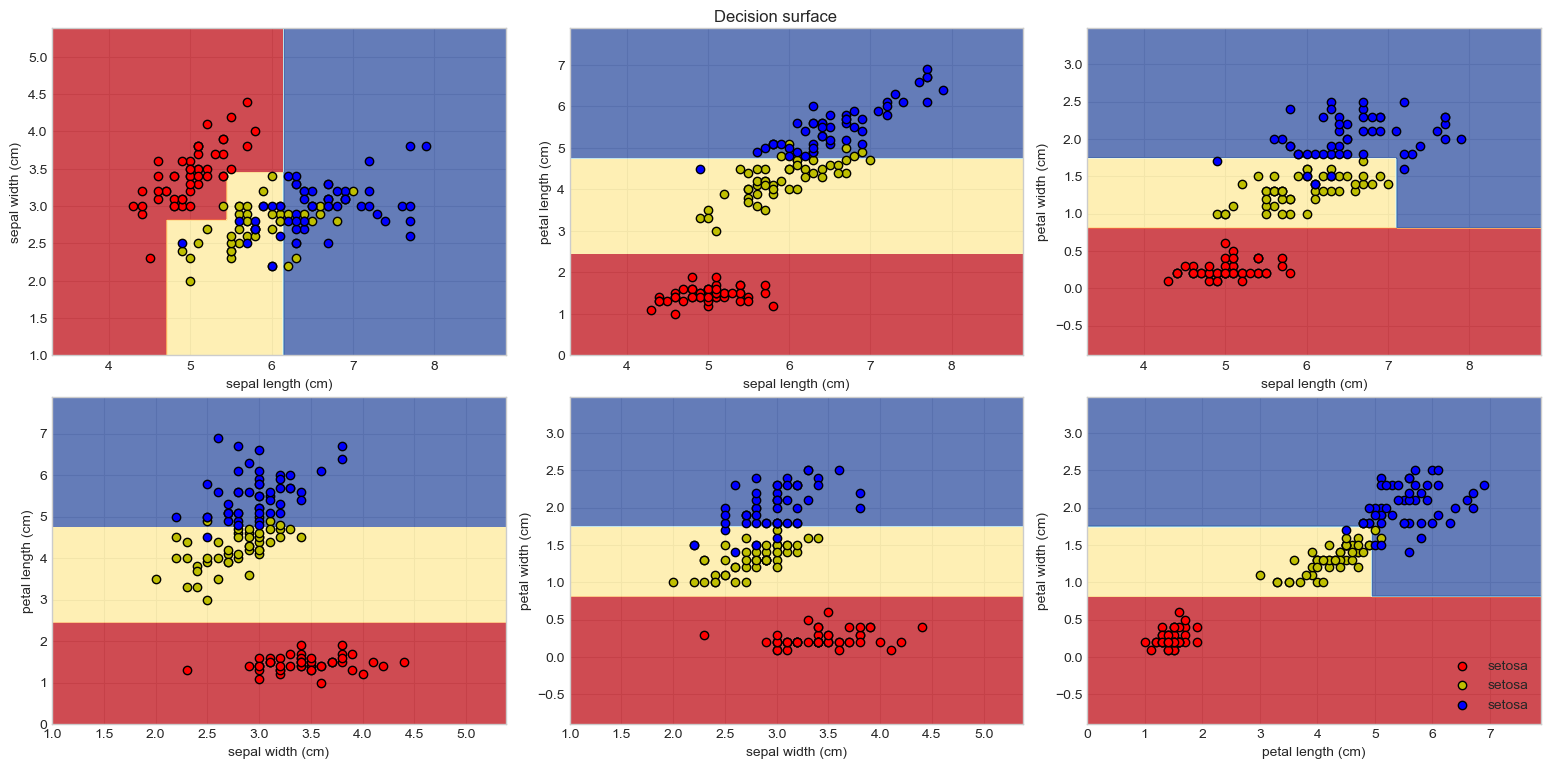

In [58]:
# 격자 그리드 데이터들의 간격
step = 0.02

# 산점도 색
colors = ["r", "y", "b"]

# figure 크기 설정
plt.figure(figsize=(16, 8))

# 붓꽃 데이터의 피처 묶음별로 그래프 생성
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    X = iris.data[:, pair]
    y = iris.target

    # 의사결정나무 학습
    model = DecisionTreeClassifier(random_state=1,
                                   max_depth=3)
    model.fit(X, y)

    # subplot 생성
    plt.subplot(2, 3, pairidx + 1)

    # 각 클래스의 영역을 구분해줄 데이터 생성
    xx, yy = get_meshgrid(X[:, 0], X[:, 1], step)

    # 각 클래스의 영역을 그래프에 구분
    get_contourf(model, xx, yy, alpha=0.8, cmap=plt.cm.RdYlBu)

    # 산점도로 시각화
    for i in range(len(np.unique(y))):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=colors[i], label=species[i], edgecolors="k")
    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.tight_layout(pad=2.5, w_pad=1.0, h_pad=0.5)

plt.suptitle("Decision surface")
plt.legend(loc="lower right")
plt.axis("tight")
plt.show()

### 유방암 데이터

In [59]:
# 유방암 데이터 불러오기
cancer = load_breast_cancer()
X, y = load_breast_cancer(return_X_y=True)

# 데이터프레임으로 만들기
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df["Target"] = cancer.target
types = cancer_df["Target"].astype(dtype="category").cat.rename_categories(cancer.target_names)
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [78]:
# 학습/테스트 데이터 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# 의사결정나무 학습
model = DecisionTreeClassifier(random_state=123)
model.fit(X_train, y_train)

# 모델 평가
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 1.0
평가 데이터 점수: 0.956140350877193


#### 교차검증 수행

In [81]:
# 의사결정나무
model = DecisionTreeClassifier(random_state=123)

# 교차검증 수행
cross_val_score(estimator=model,
                X=X, y=y,
                cv=5,
                n_jobs=multiprocessing.cpu_count())

array([0.9122807 , 0.92982456, 0.92982456, 0.9122807 , 0.89380531])

#### GridSearchCV 수행

In [99]:
# 의사결정나무
model = DecisionTreeClassifier(random_state=123)

# 파라미터 후보군
param_grid = {"min_samples_split": [2, 3, 4, 5],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
              "max_depth": [2, 3, 4],
              "max_features": ["sqrt", "log2", None]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=model,
                  param_grid=param_grid,
                  verbose=True,
                  cv=5,
                  n_jobs=multiprocessing.cpu_count())
gs.fit(X_train, y_train)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print(gs.best_score_)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
{'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 2}
0.945054945054945


#### 학습된 결정 트리 시각화

In [101]:
# 의사결정나무 학습
model = DecisionTreeClassifier(random_state=123)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

- 텍스트를 통한 시각화

In [106]:
print(export_text(decision_tree=model))

|--- feature_20 <= 16.80
|   |--- feature_27 <= 0.14
|   |   |--- feature_12 <= 6.60
|   |   |   |--- feature_21 <= 29.23
|   |   |   |   |--- class: 1
|   |   |   |--- feature_21 >  29.23
|   |   |   |   |--- feature_6 <= 0.12
|   |   |   |   |   |--- feature_11 <= 0.87
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_11 >  0.87
|   |   |   |   |   |   |--- feature_12 <= 1.47
|   |   |   |   |   |   |   |--- feature_12 <= 1.45
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_12 >  1.45
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_12 >  1.47
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_6 >  0.12
|   |   |   |   |   |--- class: 0
|   |   |--- feature_12 >  6.60
|   |   |   |--- class: 0
|   |--- feature_27 >  0.14
|   |   |--- feature_21 <= 25.67
|   |   |   |--- feature_23 <= 810.30
|   |   |   |   |--- class: 1
|   |   |   |--- feature_23 >  810.30
|   |   |   | 

- plot_tree를 사용한 시각화

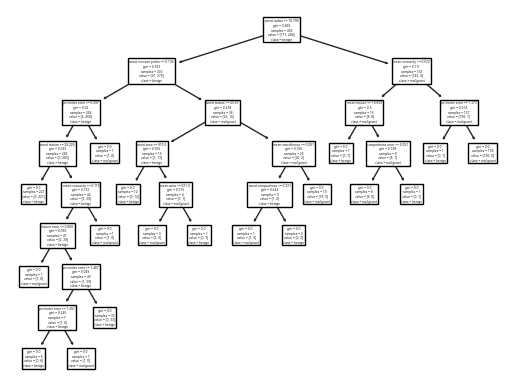

In [108]:
plot_tree(decision_tree=model,
          feature_names=cancer.feature_names,
          class_names=cancer.target_names);

- graphviz를 사용한 시각화

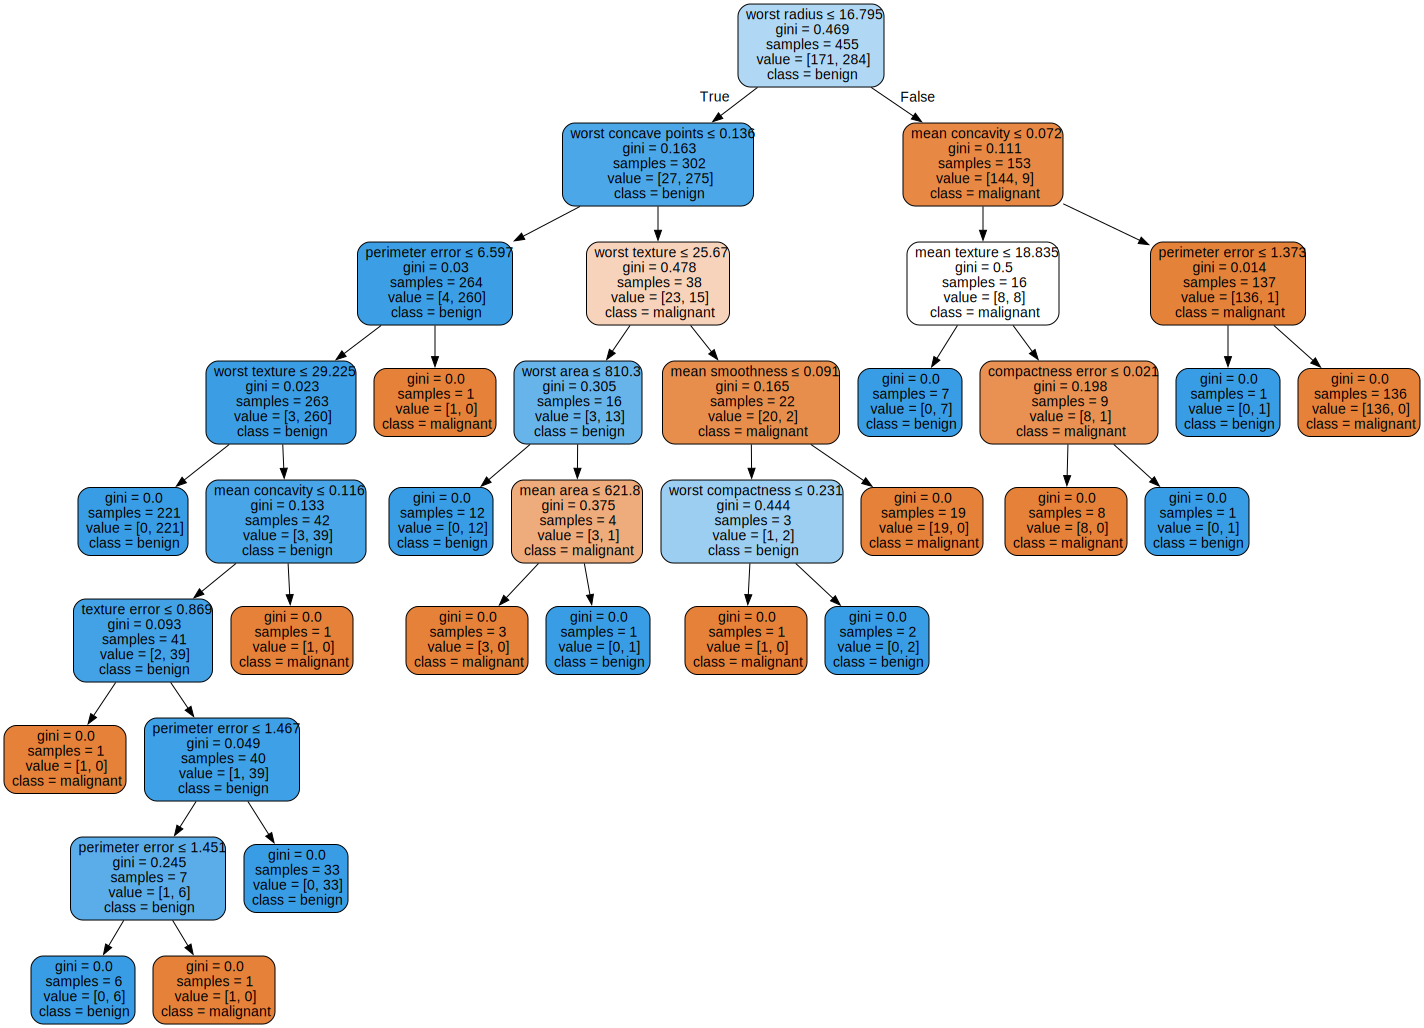

In [110]:
dot_data = export_graphviz(decision_tree=model,
                           feature_names=cancer.feature_names,
                           class_names=cancer.target_names,
                           filled=True, rounded=True,
                           special_characters=True)
graphviz.Source(dot_data)

- 결정경계 시각화

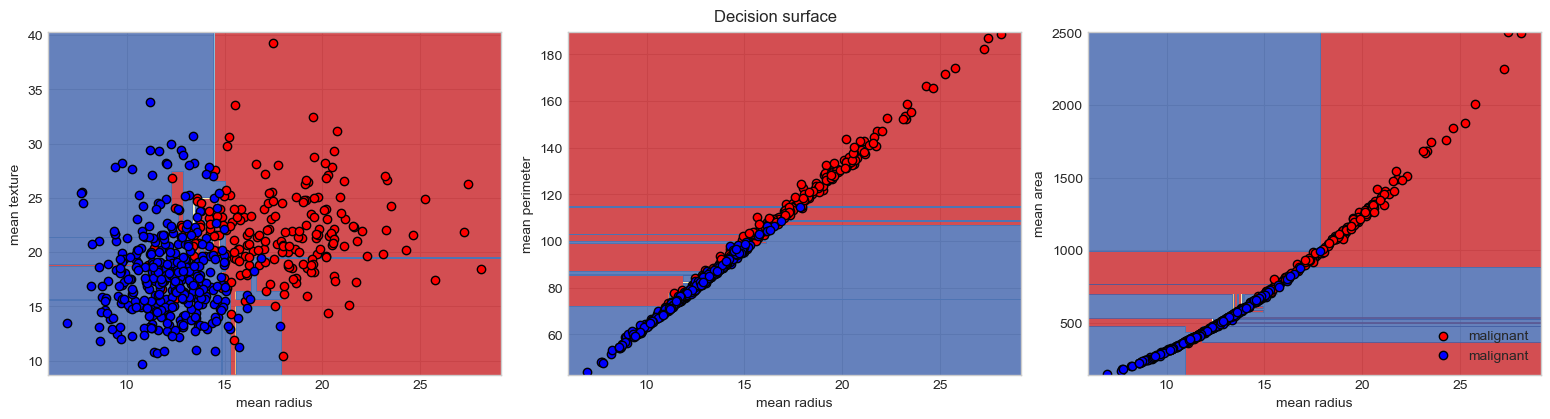

In [114]:
# 격자 그리드 데이터들의 간격
step = 0.02

# 산점도 색
colors = ["r", "b"]

# figure 크기 설정
plt.figure(figsize=(16, 8))

# 붓꽃 데이터의 피처 묶음별로 그래프 생성
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3]]):
    X = cancer.data[:, pair]
    y = cancer.target

    # 의사결정나무 학습
    model = DecisionTreeClassifier(random_state=123)
    model.fit(X, y)

    # subplot 생성
    plt.subplot(1, 3, pairidx + 1)

    # 각 클래스의 영역을 구분해줄 데이터 생성
    xx, yy = get_meshgrid(X[:, 0], X[:, 1], step)

    # 영역을 구분할 데이터들을 분류 및 영역 구분
    get_contourf(model, xx, yy, alpha=0.8, cmap=plt.cm.RdYlBu)

    # 분류된 데이터들을 산점도로 시각화
    for i in range(len(np.unique(y))):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=colors[i], edgecolors="k", label=types[i])
    plt.xlabel(cancer.feature_names[pair[0]])
    plt.ylabel(cancer.feature_names[pair[1]])
    plt.tight_layout(pad=2.5, w_pad=1.0, h_pad=0.5)

plt.legend(loc="lower right")
plt.suptitle("Decision surface")
plt.axis("tight")
plt.show()

- 하이퍼파라미터를 변경한 후 결정경계 시각화

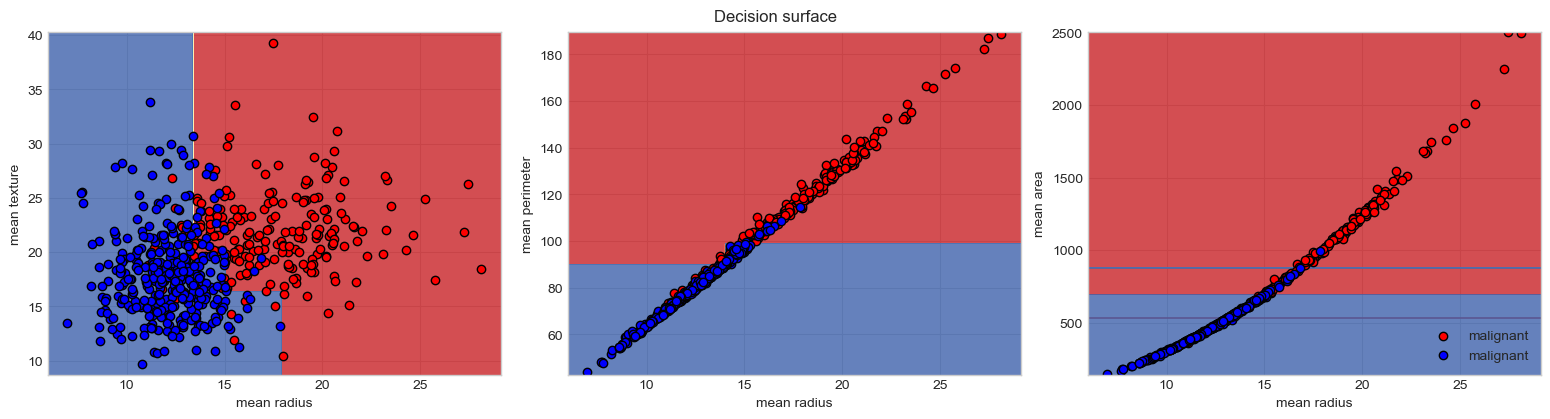

In [115]:
# 격자 그리드 데이터들의 간격
step = 0.02

# 산점도 색
colors = ["r", "b"]

# figure 크기 설정
plt.figure(figsize=(16, 8))

# 붓꽃 데이터의 피처 묶음별로 그래프 생성
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3]]):
    X = cancer.data[:, pair]
    y = cancer.target

    # 의사결정나무 학습
    model = DecisionTreeClassifier(random_state=123,
                                   max_depth=3)
    model.fit(X, y)

    # subplot 생성
    plt.subplot(2, 3, pairidx + 1)

    # 각 클래스의 영역을 구분해줄 데이터 생성
    xx, yy = get_meshgrid(X[:, 0], X[:, 1], step)

    # 영역을 구분할 데이터들을 분류 및 영역 구분
    get_contourf(model, xx, yy, alpha=0.8, cmap=plt.cm.RdYlBu)

    # 분류된 데이터들을 산점도로 시각화
    for i in range(len(np.unique(y))):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=colors[i], edgecolors="k", label=types[i])
    plt.xlabel(cancer.feature_names[pair[0]])
    plt.ylabel(cancer.feature_names[pair[1]])
    plt.tight_layout(pad=2.5, w_pad=1.0, h_pad=0.5)

plt.legend(loc="lower right")
plt.suptitle("Decision surface")
plt.axis("tight")
plt.show()

## 회귀 - DecisionTreeRegressor()

### 캘리포니아 주택 가격

In [120]:
# 캘리포니아 주택 가격 데이터 불러오기
california = fetch_california_housing()
california.data = california.data[:500, :]
california.target = california.target[:500]

# 데이터프레임으로 만들기
california_df = pd.DataFrame(california.data, columns=california.feature_names)
california_df["Target"] = california.target
california_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
495,5.3794,52.0,6.861017,1.123729,1316.0,2.230508,37.86,-122.25,3.769
496,3.2619,52.0,4.792053,1.017219,1508.0,1.997351,37.85,-122.26,3.096
497,2.7054,52.0,5.001227,1.128834,1800.0,2.208589,37.85,-122.27,1.823
498,2.2431,47.0,6.371166,1.226994,719.0,2.205521,37.85,-122.27,1.727


In [131]:
# 학습/테스트 데이터 셋 분리
X_train, X_test, y_train, y_test = train_test_split(california.data, california.target, test_size=0.2, random_state=1)

# 의사결정나무 학습
model = DecisionTreeRegressor(random_state=123)
model.fit(X_train, y_train)

# 모델 평가
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 1.0
평가 데이터 점수: 0.6976712888289044


#### 교차검증 수행

In [132]:
# 의사결정나무
model = DecisionTreeRegressor(random_state=123)

# 교차검증 수행
cross_val_score(estimator=model,
                X=california.data, y=california.target,
                cv=5,
                n_jobs=multiprocessing.cpu_count())

array([-0.4436282 ,  0.37769059, -0.07381325,  0.56458819,  0.34815004])

#### GridSearchCV 수행

In [137]:
# 의사결정나무
model = DecisionTreeRegressor(random_state=123)

# 파라미터 후보군
param_grid = {"min_samples_split": [2, 3, 4, 5],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
              "max_depth": [2, 3, 4],
              "max_features": ["sqrt", "log2", None]}

# GridSearchCV 수행
gs = GridSearchCV(estimator=model,
                  param_grid=param_grid,
                  cv=5,
                  verbose=True,
                  n_jobs=multiprocessing.cpu_count())
gs.fit(X_train, y_train)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print(gs.best_score_)

# 모델 평가
model = gs.best_estimator_
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
{'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4}
0.6625590564772417
학습 데이터 점수: 0.8168027708936784
평가 데이터 점수: 0.7943496455419579


#### 학습된 결정 트리 시각화

In [138]:
# 의사결정나무 학습
model = DecisionTreeRegressor(random_state=123)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=123)

- 텍스트를 통한 시각화

In [139]:
print(export_text(decision_tree=model,
                  feature_names=california.feature_names))

|--- MedInc <= 4.80
|   |--- Latitude <= 37.85
|   |   |--- AveOccup <= 2.38
|   |   |   |--- MedInc <= 2.57
|   |   |   |   |--- Longitude <= -122.26
|   |   |   |   |   |--- AveBedrms <= 0.98
|   |   |   |   |   |   |--- MedInc <= 1.99
|   |   |   |   |   |   |   |--- value: [1.04]
|   |   |   |   |   |   |--- MedInc >  1.99
|   |   |   |   |   |   |   |--- value: [0.60]
|   |   |   |   |   |--- AveBedrms >  0.98
|   |   |   |   |   |   |--- AveBedrms <= 1.06
|   |   |   |   |   |   |   |--- MedInc <= 1.36
|   |   |   |   |   |   |   |   |--- MedInc <= 0.84
|   |   |   |   |   |   |   |   |   |--- value: [1.62]
|   |   |   |   |   |   |   |   |--- MedInc >  0.84
|   |   |   |   |   |   |   |   |   |--- AveOccup <= 1.71
|   |   |   |   |   |   |   |   |   |   |--- Population <= 1379.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.72]
|   |   |   |   |   |   |   |   |   |   |--- Population >  1379.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.70]
|   |   |

- plot_tree를 사용한 시각화

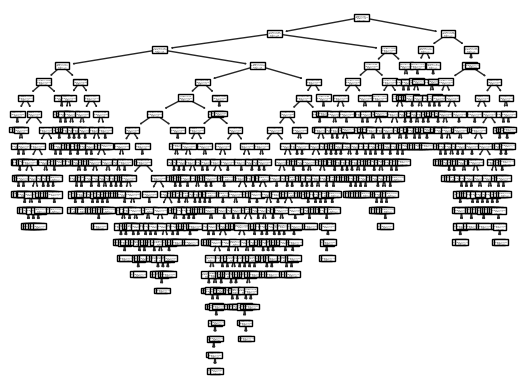

In [141]:
plot_tree(decision_tree=model,
          feature_names=california.feature_names,
          class_names=california.target_names);

- graphviz를 사용한 시각화

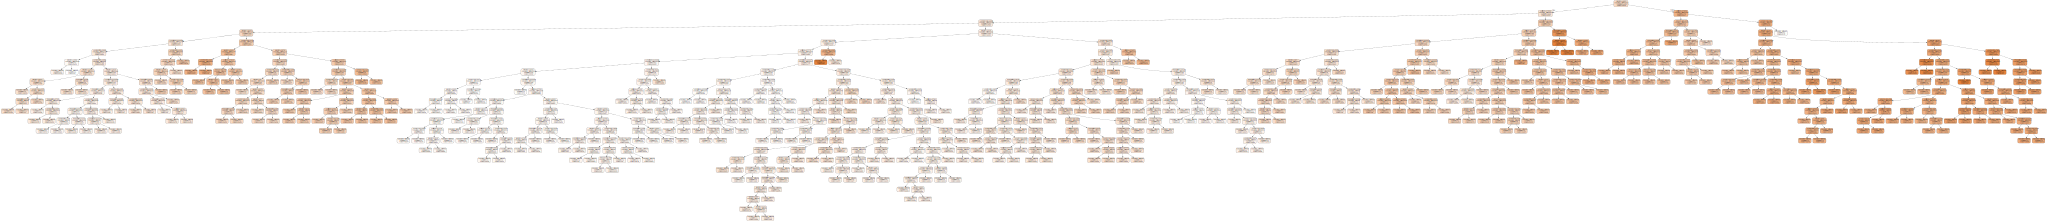

In [142]:
dot_data = export_graphviz(decision_tree=model,
                           feature_names=california.feature_names,
                           class_names=california.target_names,
                           filled=True, rounded=True,
                           special_characters=True)
graphviz.Source(dot_data)

- 결정경계 시각화

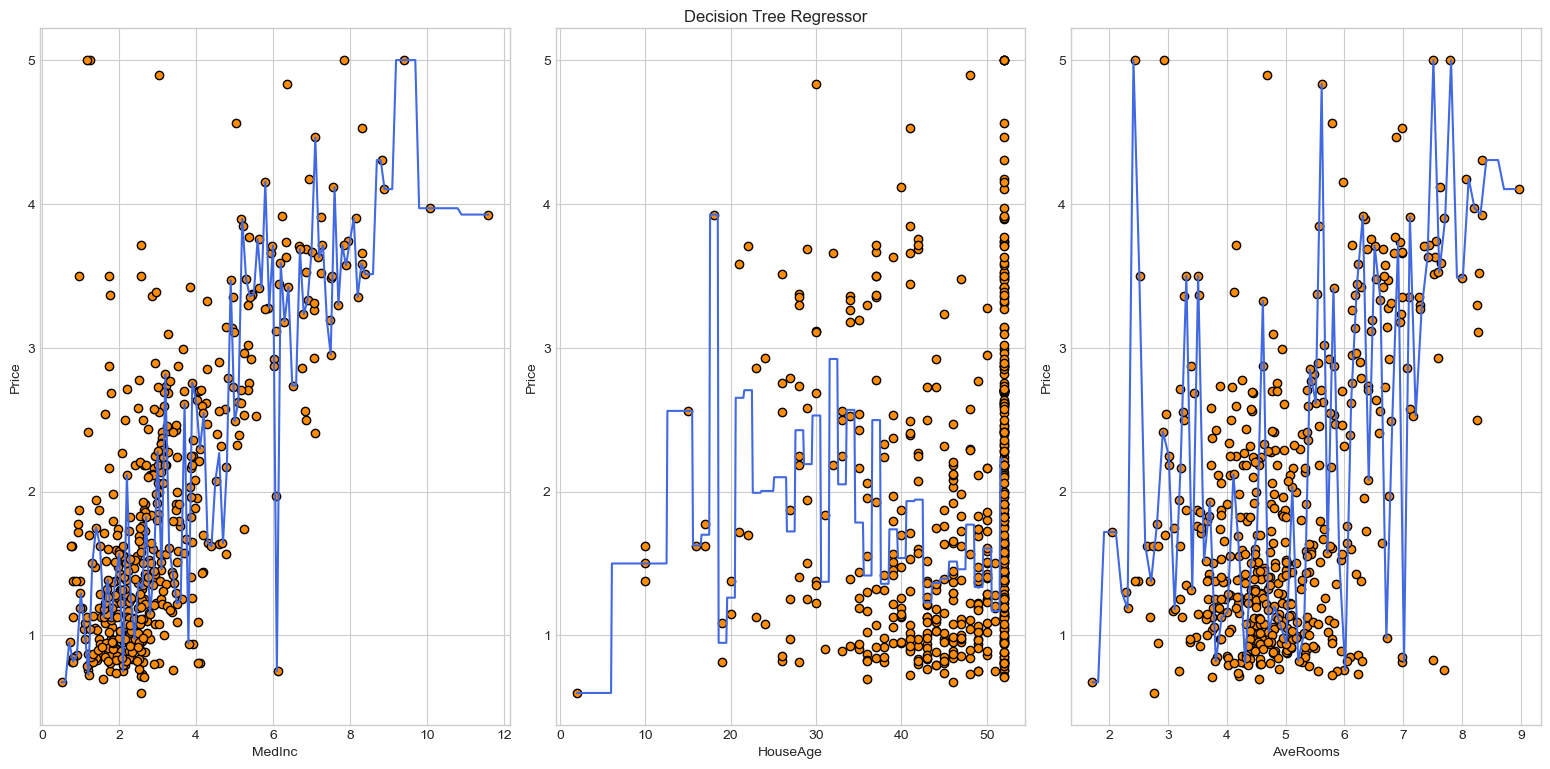

In [152]:
# figure 크기 설정
plt.figure(figsize=(16, 8))

for pairidx, pair in enumerate([0, 1, 2]):
    X = california.data[:, pair][:, np.newaxis]
    y = california.target

    # 의사결정나무 학습 및 예측 데이터 생성
    model = DecisionTreeRegressor(random_state=123)
    model.fit(X, y)
    X_test = np.arange(X.min(), X.max(), 0.1)[:, np.newaxis]
    y_predict = model.predict(X_test)

    # subplot 생성
    plt.subplot(1, 3, pairidx + 1)
    
    # 실제 주택 가격
    plt.scatter(X, y, color="darkorange", edgecolors="k")

    # 예측 주택 가격
    plt.plot(X_test, y_predict, color="royalblue")
    
    plt.xlabel(california.feature_names[pair])
    plt.ylabel("Price")
    plt.tight_layout(pad=2.5, w_pad=1.0, h_pad=0.5)

plt.suptitle("Decision Tree Regressor")
plt.axis("tight")
plt.show()

- 하이퍼파라미터를 변경한 후 결정경계 시각화

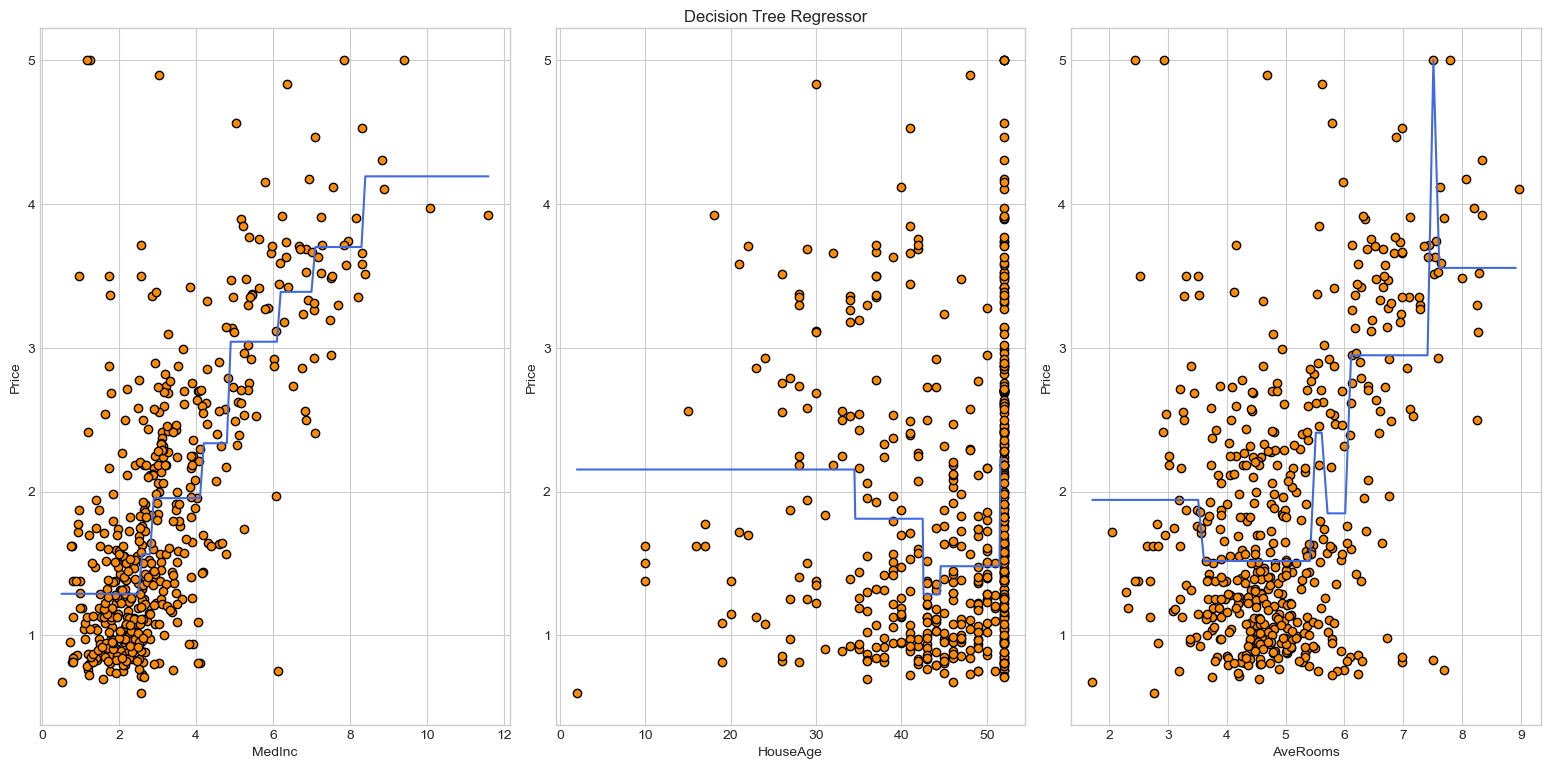

In [153]:
# figure 크기 설정
plt.figure(figsize=(16, 8))

for pairidx, pair in enumerate([0, 1, 2]):
    X = california.data[:, pair][:, np.newaxis]
    y = california.target

    # 의사결정나무 학습 및 예측 데이터 생성
    model = DecisionTreeRegressor(random_state=123,
                                  max_depth=3)
    model.fit(X, y)
    X_test = np.arange(X.min(), X.max(), 0.1)[:, np.newaxis]
    y_predict = model.predict(X_test)

    # subplot 생성
    plt.subplot(1, 3, pairidx + 1)
    
    # 실제 주택 가격
    plt.scatter(X, y, color="darkorange", edgecolors="k")

    # 예측 주택 가격
    plt.plot(X_test, y_predict, color="royalblue")
    
    plt.xlabel(california.feature_names[pair])
    plt.ylabel("Price")
    plt.tight_layout(pad=2.5, w_pad=1.0, h_pad=0.5)

plt.suptitle("Decision Tree Regressor")
plt.axis("tight")
plt.show()

### 당뇨병 데이터

In [166]:
# 당뇨병 데이터 불러오기
diabetes = load_diabetes()
X, y = load_diabetes(return_X_y=True)

# 데이터프레임으로 만들기
diabetes_df = pd.DataFrame(diabetes.data, diabetes.target, columns=diabetes.feature_names)
diabetes_df["Target"] = diabetes.target
diabetes_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Target
151.0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
75.0,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
141.0,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
206.0,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
135.0,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
178.0,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
104.0,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
132.0,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
220.0,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


In [183]:
# 학습/테스트 데이터 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# 의사결정나무 학습
model = DecisionTreeRegressor(random_state=123)
model.fit(X_train, y_train)

# 모델 평가
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 1.0
평가 데이터 점수: 0.15795709914946876


#### 교차검증 수행

In [185]:
# 의사결정나무
model = DecisionTreeRegressor(random_state=123)

# 교차검증 수행
cross_val_score(estimator=model,
                X=X, y=y,
                n_jobs=multiprocessing.cpu_count(),
                cv=5)

array([-0.29566162, -0.10108027,  0.04790773, -0.0078073 , -0.1978206 ])

#### GridSearchCV 수행

In [190]:
# 의사결정나무
model = DecisionTreeRegressor(random_state=123)

# 파라미터 후보군
param_grid = {"min_samples_split": [2, 3, 4, 5],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
              "max_depth": [2, 3, 4],
              "max_features": ["sqrt", "log2", None]}

# GridSearchCV 수행
cv = KFold(10, shuffle=True, random_state=123)
gs = GridSearchCV(estimator=model,
                  param_grid=param_grid,
                  cv=cv,
                  verbose=True,
                  n_jobs=multiprocessing.cpu_count())
gs.fit(X_train, y_train)

# 최적의 파라미터
print(gs.best_params_)

# 최적의 파라미터의 점수
print(gs.best_score_)

# 모델 평가
model = gs.best_estimator_
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

Fitting 10 folds for each of 252 candidates, totalling 2520 fits
{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 2}
0.30936371538705076
학습 데이터 점수: 0.5092049481969281
평가 데이터 점수: 0.40720701851238683


#### 학습된 결정 트리 시각화

In [192]:
# 의사결정나무 학습
model = DecisionTreeRegressor(random_state=123)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=123)

- 텍스트를 통한 시각화

In [193]:
print(export_text(decision_tree=model,
                  feature_names=diabetes.feature_names))

|--- s5 <= -0.00
|   |--- bmi <= 0.01
|   |   |--- s2 <= 0.11
|   |   |   |--- s3 <= 0.02
|   |   |   |   |--- sex <= 0.00
|   |   |   |   |   |--- s3 <= 0.02
|   |   |   |   |   |   |--- age <= -0.04
|   |   |   |   |   |   |   |--- bmi <= -0.04
|   |   |   |   |   |   |   |   |--- s3 <= 0.01
|   |   |   |   |   |   |   |   |   |--- s6 <= -0.06
|   |   |   |   |   |   |   |   |   |   |--- bmi <= -0.07
|   |   |   |   |   |   |   |   |   |   |   |--- value: [134.00]
|   |   |   |   |   |   |   |   |   |   |--- bmi >  -0.07
|   |   |   |   |   |   |   |   |   |   |   |--- value: [142.00]
|   |   |   |   |   |   |   |   |   |--- s6 >  -0.06
|   |   |   |   |   |   |   |   |   |   |--- bmi <= -0.06
|   |   |   |   |   |   |   |   |   |   |   |--- value: [101.00]
|   |   |   |   |   |   |   |   |   |   |--- bmi >  -0.06
|   |   |   |   |   |   |   |   |   |   |   |--- value: [113.00]
|   |   |   |   |   |   |   |   |--- s3 >  0.01
|   |   |   |   |   |   |   |   |   |--- value: [69.00]
|  

- plot_tree를 사용한 시각화

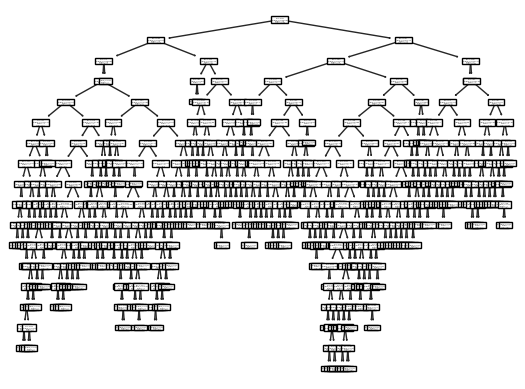

In [195]:
plot_tree(decision_tree=model,
          feature_names=diabetes.feature_names);

- graphviz를 사용한 시각화

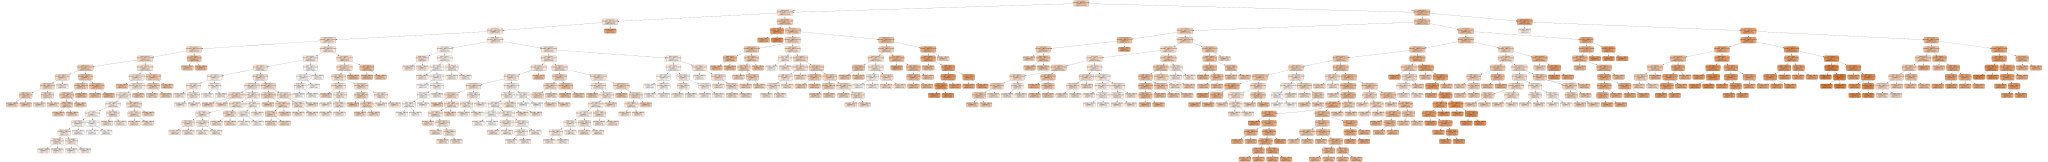

In [196]:
dot_data = export_graphviz(decision_tree=model,
                           feature_names=diabetes.feature_names,
                           filled=True, rounded=True)
graphviz.Source(dot_data)

- 결정경계 시각화

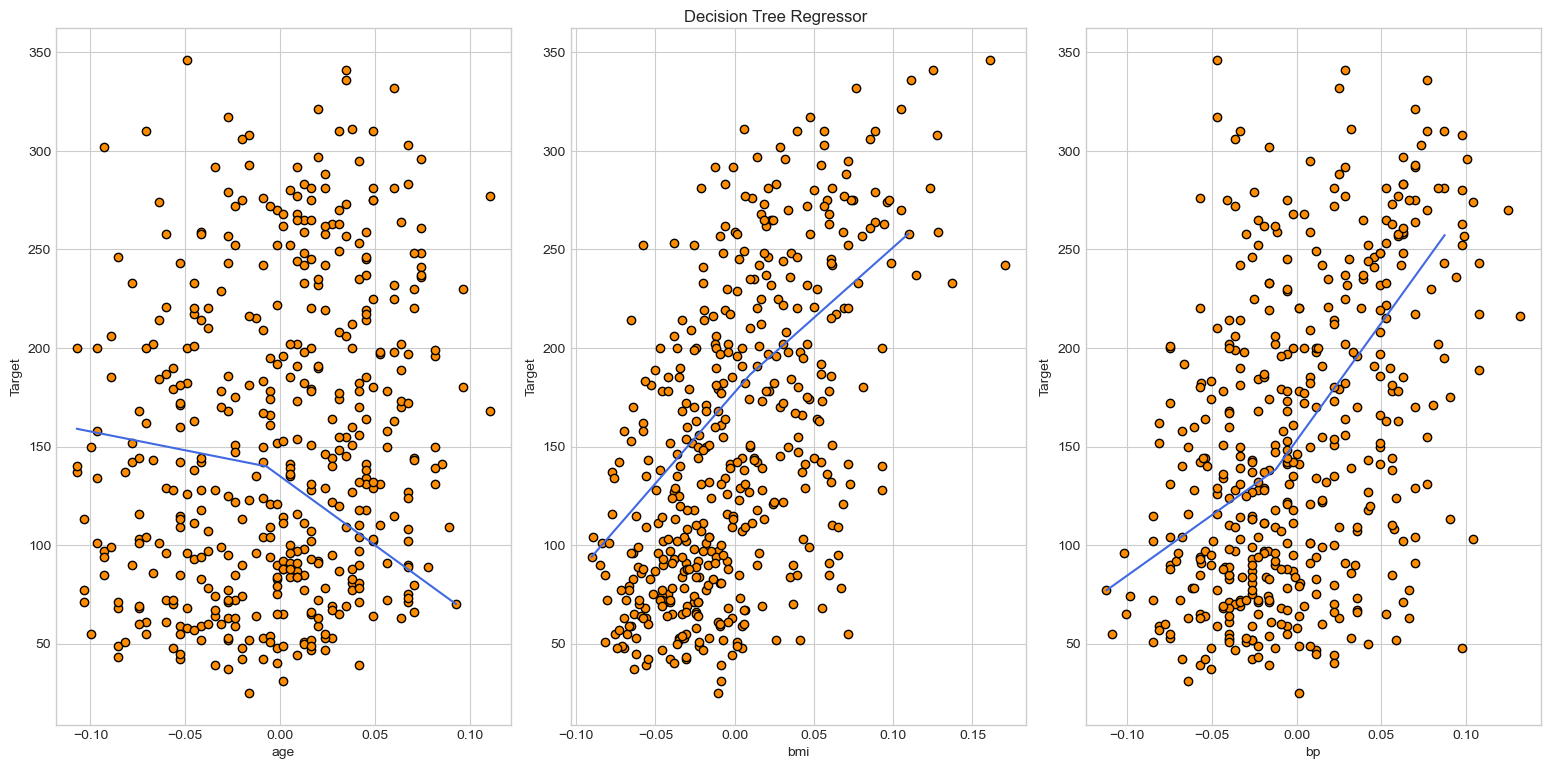

In [198]:
# figure 크기 설정
plt.figure(figsize=(16, 8))

for pairidx, pair in enumerate([0, 2, 3]):
    X = diabetes.data[:, pair][:, np.newaxis]
    y = diabetes.target

    # 의사결정나무 학습
    model = DecisionTreeRegressor(random_state=123)
    model.fit(X, y)
    X_test = np.arange(X.min(), X.max(), 0.1)[:, np.newaxis]
    y_predict = model.predict(X_test)

    # subplot 생성
    plt.subplot(1, 3, pairidx + 1)

    # 실제 당뇨 수치
    plt.scatter(X, y, color="darkorange", edgecolors="k")

    # 예측 당뇨 수치
    plt.plot(X_test, y_predict, color="royalblue")

    plt.xlabel(diabetes.feature_names[pair])
    plt.ylabel("Target")
    plt.tight_layout(pad=2.5, w_pad=1.0, h_pad=0.5)

plt.suptitle("Decision Tree Regressor")
plt.axis("tight")
plt.show()